In [93]:
# !pip install scikit-plot

In [94]:
# %pip install scipy==1.11.4

In [2]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

c:\Users\rajpo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("Insurance.csv")

In [4]:
df.shape

(1338, 8)

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [6]:
target = 'insuranceclaim'
labels = ['Claimed','Not Claimed']
features = [i for i in df.columns.values if i not in [target]]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   int64  
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   int64  
 5   region          1338 non-null   int64  
 6   charges         1338 non-null   float64
 7   insuranceclaim  1338 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


In [8]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

sex                  2
smoker               2
insuranceclaim       2
region               4
children             6
age                 47
bmi                548
charges           1337
dtype: int64

In [9]:
df.isnull().sum()

age               0
sex               0
bmi               0
children          0
smoker            0
region            0
charges           0
insuranceclaim    0
dtype: int64

# EDA

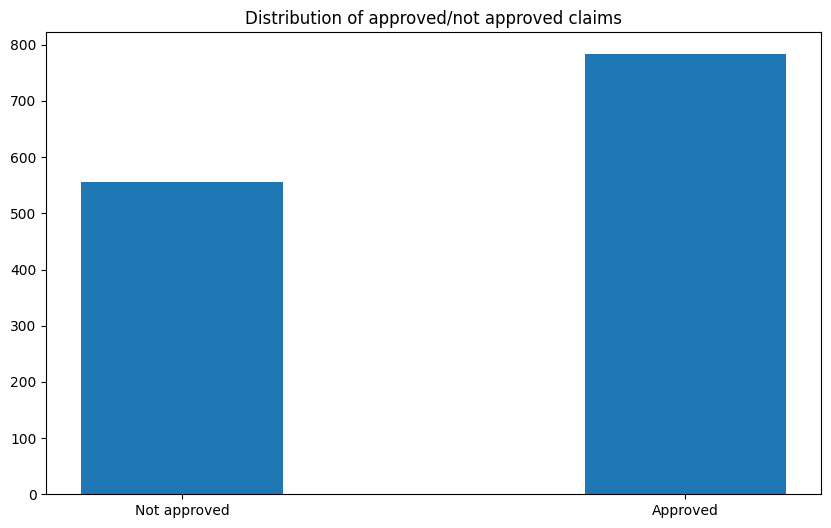

Percentage of approved claims:59%
Percentage of NOT approved claims:41%


In [10]:
# Distribution of Approved and Not Approved Claims:

counts = df['insuranceclaim'].value_counts()
x_axis = ['Not approved', 'Approved']
y_axis = [counts[0],counts[1]]
plt.bar(x_axis,y_axis,width = 0.4)
plt.title('Distribution of approved/not approved claims')
plt.show()

print('Percentage of approved claims:{}%'.format(round((counts[1]*100)/len(df)),2))
print('Percentage of NOT approved claims:{}%'.format(round((counts[0]*100)/len(df)),2))

# Univariate Analysis

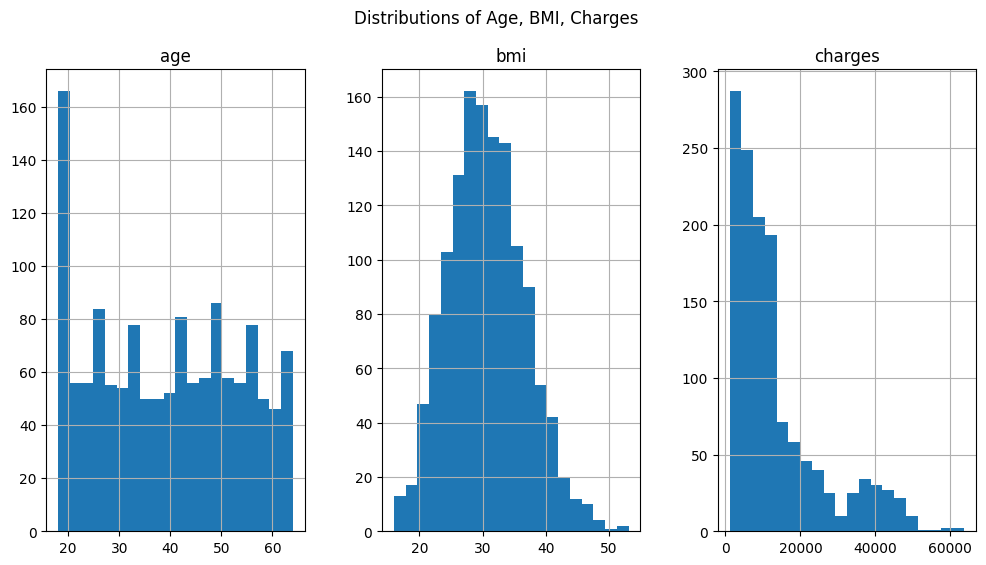

In [11]:
# Numeric features
num_cols = ['age', 'bmi', 'charges']
df[num_cols].hist(bins=20, figsize=(12, 6), layout=(1, 3))
plt.suptitle('Distributions of Age, BMI, Charges')
plt.show()

# Bivariate Analysis

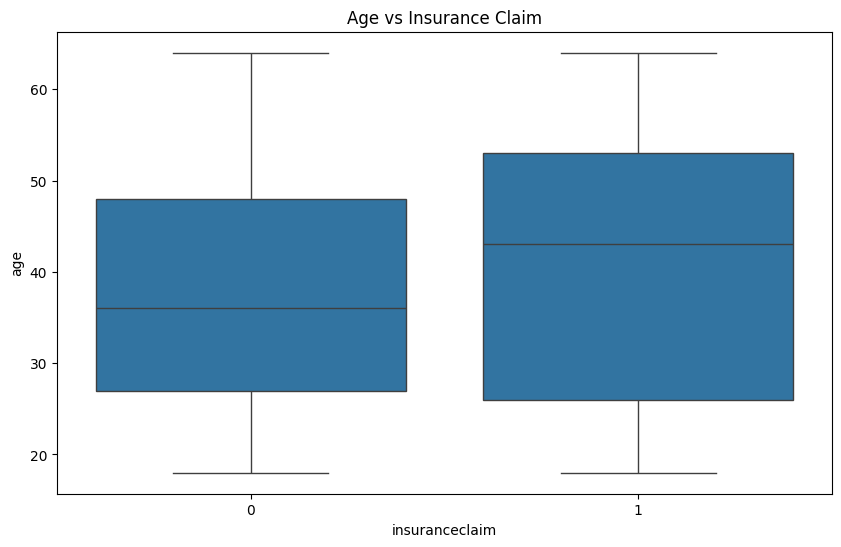

In [12]:
sns.boxplot(x='insuranceclaim', y='age', data=df)
plt.title('Age vs Insurance Claim')
plt.show()


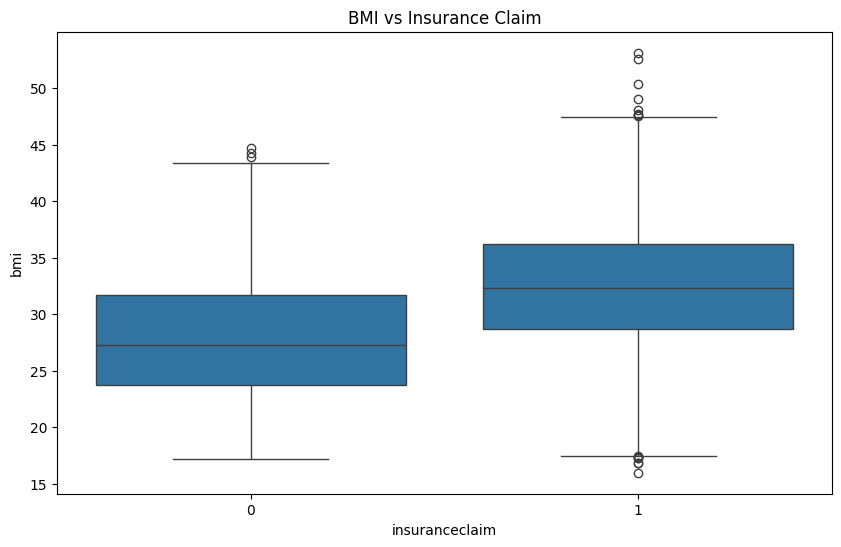

In [13]:
sns.boxplot(x='insuranceclaim', y='bmi', data=df)
plt.title('BMI vs Insurance Claim')
plt.show()


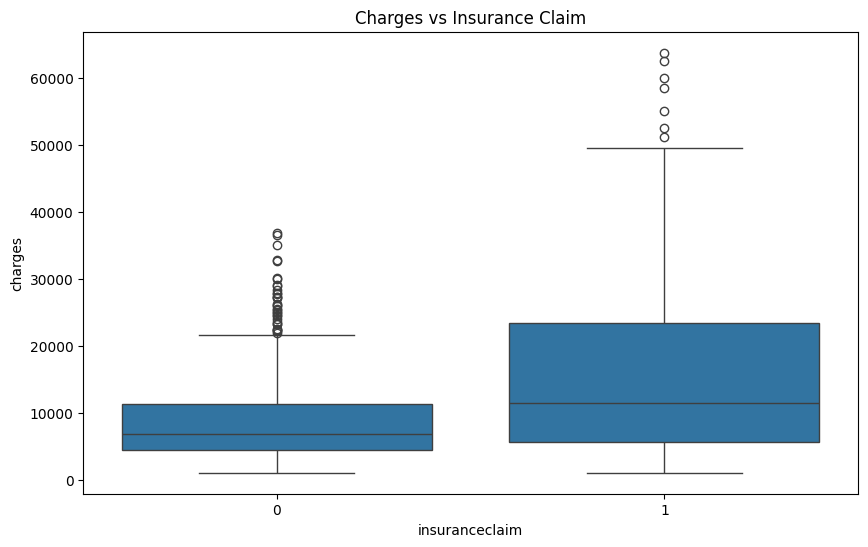

In [14]:
sns.boxplot(x='insuranceclaim', y='charges', data=df)
plt.title('Charges vs Insurance Claim')
plt.show()


# Categorical Feature vs Target Feature

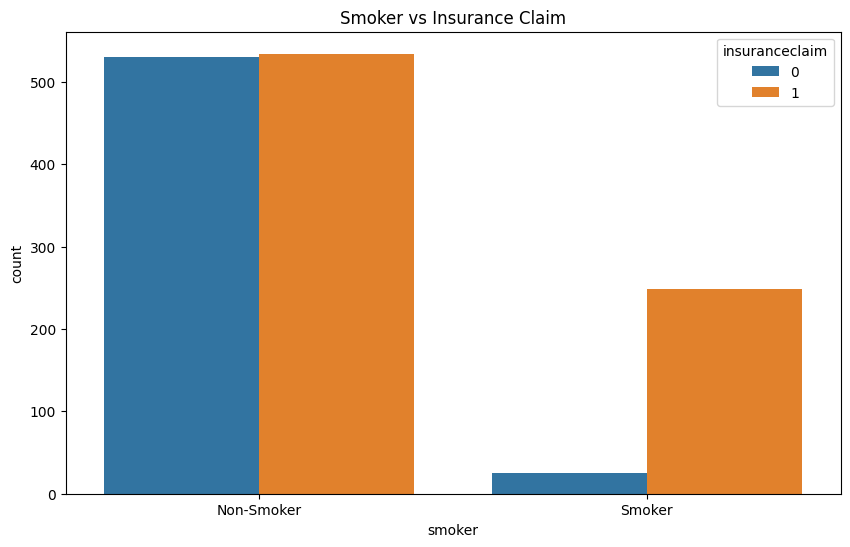

In [15]:
sns.countplot(x='smoker', hue='insuranceclaim', data=df)
plt.title('Smoker vs Insurance Claim')
plt.xticks([0,1], ['Non-Smoker', 'Smoker'])
plt.show()


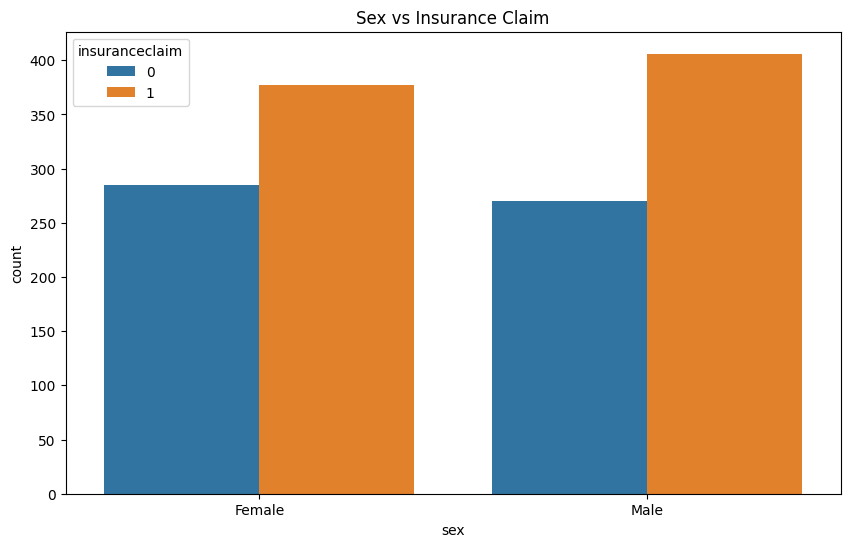

In [16]:
sns.countplot(x='sex', hue='insuranceclaim', data=df)
plt.title('Sex vs Insurance Claim')
plt.xticks([0,1], ['Female', 'Male'])
plt.show()


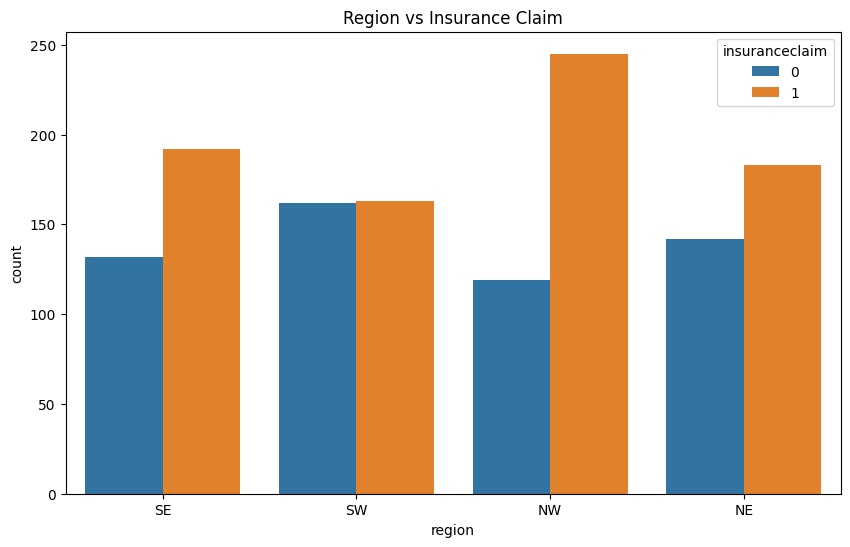

In [17]:
sns.countplot(x='region', hue='insuranceclaim', data=df)
plt.title('Region vs Insurance Claim')
plt.xticks([0,1,2,3], ['SE', 'SW', 'NW', 'NE'])  # Adjust if encoded
plt.show()


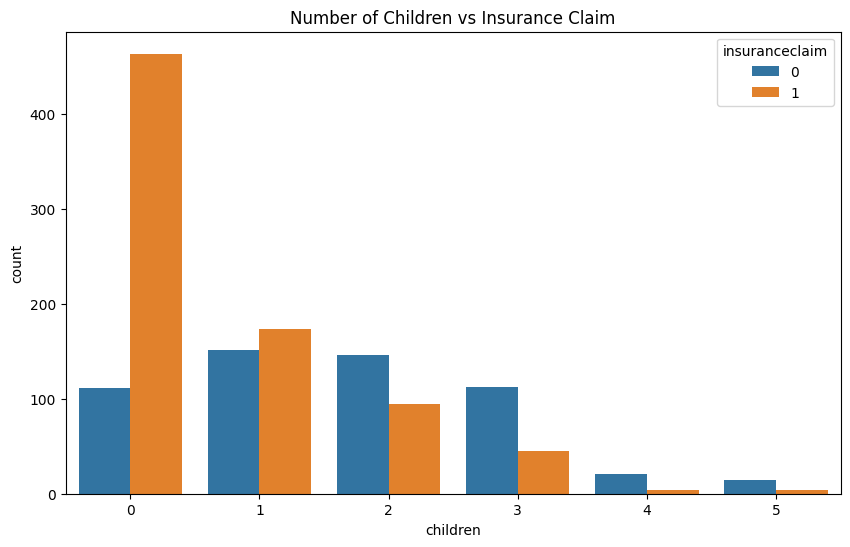

In [18]:
sns.countplot(x='children', hue='insuranceclaim', data=df)
plt.title('Number of Children vs Insurance Claim')
plt.show()


# Pairplot

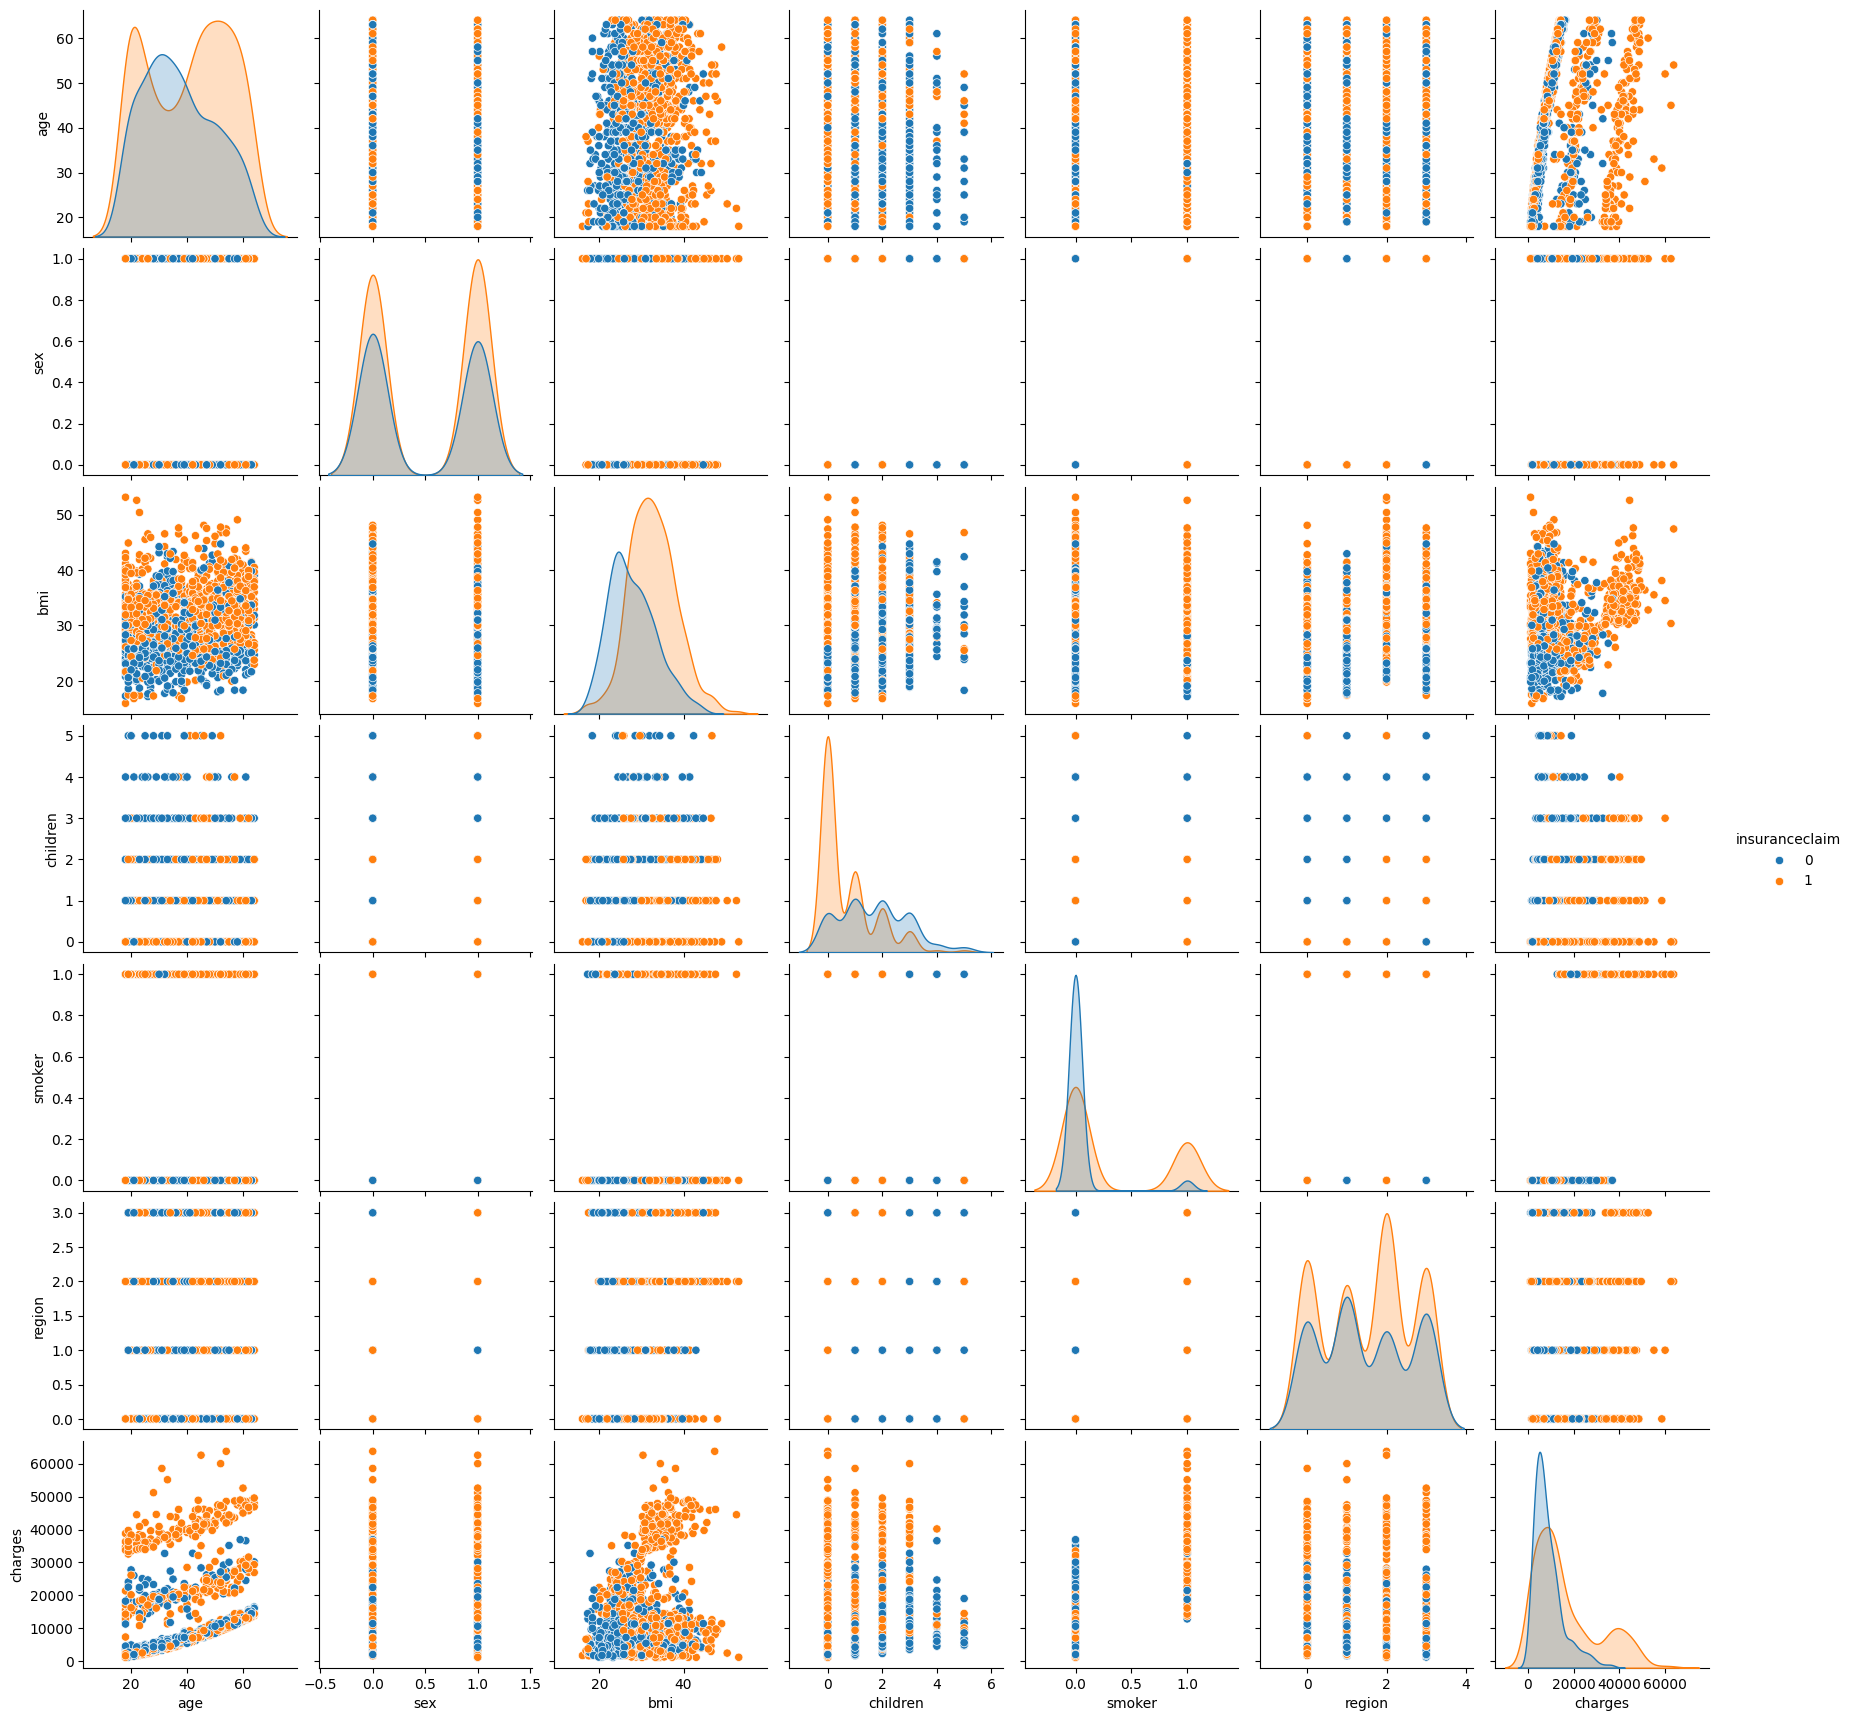

In [19]:
sns.pairplot(df, hue='insuranceclaim', diag_kind='kde')


In [20]:
df.groupby('insuranceclaim')[['age', 'bmi', 'charges', 'children']].mean()


,age,bmi,charges,children
insuranceclaim,,,,
0,37.309910,27.881586,8821.421892,1.681081
1,40.551724,32.635179,16423.928277,0.679438


# Data Preprocessing

In [21]:
# 1️⃣ Original Data
original_df = df.copy()
initial_rows = len(df)
print(f"📌 Original rows: {initial_rows}")

# 2️⃣ Remove Duplicate Rows
num_duplicates = df.duplicated().sum()
print(f"\n🧹 Duplicate rows found: {num_duplicates}")

df_no_duplicates = df.drop_duplicates()
rows_after_duplicates = len(df_no_duplicates)
dropped_duplicates = initial_rows - rows_after_duplicates
print(f"✅ Rows after dropping duplicates: {rows_after_duplicates}")
print(f"🗑️  Rows dropped (duplicates): {dropped_duplicates}")

📌 Original rows: 1338

🧹 Duplicate rows found: 1
✅ Rows after dropping duplicates: 1337
🗑️  Rows dropped (duplicates): 1


# Split into train and test dataset

In [23]:
X = df.drop('insuranceclaim', axis=1)
y = df['insuranceclaim']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine train set for outlier removal
train_df = X_train.copy()
train_df['insuranceclaim'] = y_train


# Outlier Detection and Removal

In [24]:
def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    outlier_rows = set()

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_rows.update(outliers.index)

        print(f"🧪 {col}: {outliers.shape[0]} outliers detected")

    df_cleaned = df.drop(index=outlier_rows)
    print(f"\n📉 Total unique rows removed as outliers: {len(outlier_rows)}")
    return df_cleaned, len(outlier_rows)

In [25]:
# Remove outliers only from training set
train_df_cleaned, _ = remove_outliers_iqr(train_df, ['bmi', 'charges', 'age'])

# Separate again
X_train = train_df_cleaned.drop('insuranceclaim', axis=1)
y_train = train_df_cleaned['insuranceclaim']

🧪 bmi: 5 outliers detected
🧪 charges: 107 outliers detected
🧪 age: 0 outliers detected

📉 Total unique rows removed as outliers: 110


In [26]:
X_train.shape, y_train.shape

((960, 7), (960,))

In [27]:
X_test.shape, y_test.shape

((268, 7), (268,))

# Check Coorelation

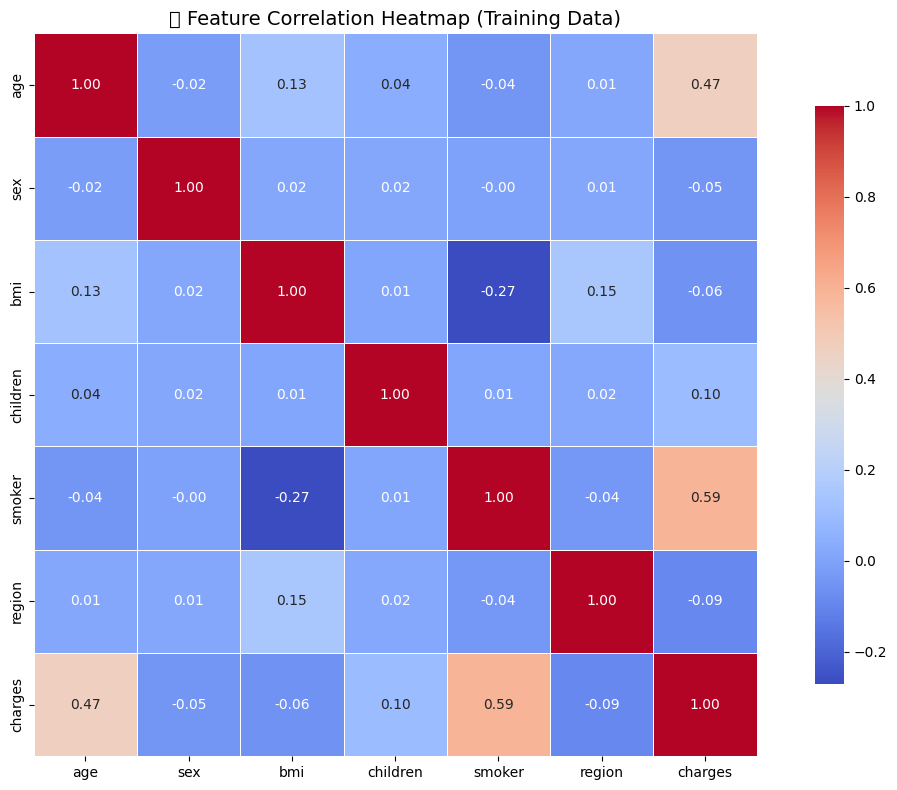

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    X_train.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("🔗 Feature Correlation Heatmap (Training Data)", fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
corr_matrix = X_train.corr().abs()

# 2️⃣ Select upper triangle of correlation matrix (to avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3️⃣ Find features with correlation > threshold (e.g., 0.9)
correlation_threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

print(f"🔍 Features to drop due to high correlation (> {correlation_threshold}): {to_drop}")

# 4️⃣ Drop the features from both train and test sets
# X_train = X_train.drop(columns=to_drop)
# X_test = X_test.drop(columns=to_drop)

🔍 Features to drop due to high correlation (> 0.9): []


In [30]:
X_train.head()

,age,sex,bmi,children,smoker,region,charges
1254,34,0,27.72,0,0,2,4415.15880
182,22,1,19.95,3,0,0,4005.42250
1308,25,0,30.20,0,1,3,33900.65300
1215,18,1,39.14,0,0,0,12890.05765
532,59,1,29.70,2,0,2,12925.88600


In [31]:
y_train.head()

1254    1
182     0
1308    1
1215    1
532     1
Name: insuranceclaim, dtype: int64

# Log transform Charges Variable

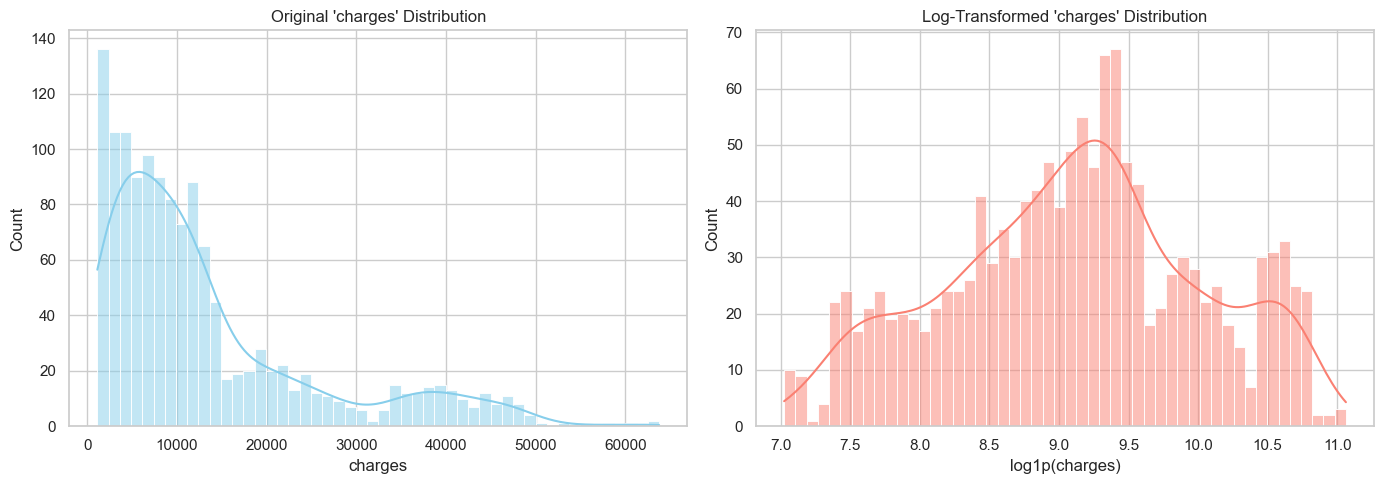

In [32]:
# Create a copy to preserve original
df_viz = df.copy()

# Set plot style
sns.set(style="whitegrid")

# Create transformed column
df_viz['log_charges'] = np.log1p(df_viz['charges'])

# Plot original vs log-transformed
plt.figure(figsize=(14, 5))

# Original charges
plt.subplot(1, 2, 1)
sns.histplot(df_viz['charges'], bins=50, kde=True, color='skyblue')
plt.title("Original 'charges' Distribution")
plt.xlabel("charges")

# Log-transformed charges
plt.subplot(1, 2, 2)
sns.histplot(df_viz['log_charges'], bins=50, kde=True, color='salmon')
plt.title("Log-Transformed 'charges' Distribution")
plt.xlabel("log1p(charges)")

plt.tight_layout()
plt.show()

In [33]:
X_train['charges'] = np.log1p(X_train['charges'])
X_test['charges'] = np.log1p(X_test['charges'])

In [34]:
# Define numeric columns to scale
num_cols = ['age', 'bmi', 'charges']

# Initialize scaler
scaler = StandardScaler()

# Fit only on training data, transform both
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [35]:
X_train

,age,sex,bmi,children,smoker,region,charges
1254,-0.358771,0,-0.399016,0,0,2,-0.650470
182,-1.214297,1,-1.726263,3,0,0,-0.772352
1308,-1.000416,0,0.024610,0,1,3,1.900762
1215,-1.499472,1,1.551713,0,0,0,0.690444
532,1.423574,1,-0.060798,2,0,2,0.693918
...,...,...,...,...,...,...,...
319,-0.501359,1,1.243389,1,0,0,-0.580887
219,-1.071709,0,-1.169400,0,0,2,1.523642
209,0.068992,1,1.908720,1,0,0,-0.145428
1280,0.639342,0,0.559267,0,0,2,0.137029


In [36]:
X_test

,age,sex,bmi,children,smoker,region,charges
19,-0.643946,1,0.895776,0,1,3,2.004753
201,0.639342,0,0.371368,1,0,2,0.222783
222,-0.501359,1,0.127100,3,0,3,-0.432899
750,-0.144890,0,-0.624494,0,1,2,1.211084
543,1.067105,0,2.964369,0,1,2,2.691646
...,...,...,...,...,...,...,...
867,1.280986,1,2.330638,1,0,3,0.555882
339,0.496754,0,-0.399016,1,0,2,0.129294
653,0.425461,0,1.066593,2,0,2,0.173340
467,1.209693,0,0.642967,2,0,1,0.666259


# Encode categorical Features

In [37]:
# Define columns to encode
categorical_cols = ['region', 'children']

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Fit on training data only
encoded_train = encoder.fit_transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

In [38]:
encoded_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], shape=(960, 8))

In [39]:
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

In [40]:
encoded_train_df

,region_1,region_2,region_3,children_1,children_2,children_3,children_4,children_5
1254,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
182,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1308,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
319,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
219,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1280,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Drop original categorical columns
X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)

# Concatenate encoded columns
X_train = pd.concat([X_train, encoded_train_df], axis=1)
X_test = pd.concat([X_test, encoded_test_df], axis=1)

In [42]:
X_train.shape, y_train.shape

((960, 13), (960,))

In [43]:
X_test.shape, y_test.shape

((268, 13), (268,))

# ML Modeling

In [44]:
def evaluate_model(y_true, y_pred, y_proba=None):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
    }

    if y_proba is not None:
        metrics['ROC AUC'] = roc_auc_score(y_true, y_proba)

    return metrics


In [45]:
def run_logistic_regression(X_train, X_test, y_train, y_test):
    # print("\n🔍 Logistic Regression")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return evaluate_model(y_test, y_pred, y_proba)  # <-- return this


def run_svm(X_train, X_test, y_train, y_test):
    # print("\n🔍 SVM")
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return evaluate_model(y_test, y_pred, y_proba)

def run_decision_tree(X_train, X_test, y_train, y_test):
    # print("\n🔍 Decision Tree")
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return evaluate_model(y_test, y_pred, y_proba)

def run_xgboost(X_train, X_test, y_train, y_test):
    # print("\n🔍 XGBoost")
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return evaluate_model(y_test, y_pred, y_proba)



In [46]:
results = {
    'Logistic Regression': run_logistic_regression(X_train, X_test, y_train, y_test),
    'SVM': run_svm(X_train, X_test, y_train, y_test),
    'Decision Tree': run_decision_tree(X_train, X_test, y_train, y_test),
    'XGBoost': run_xgboost(X_train, X_test, y_train, y_test)
}


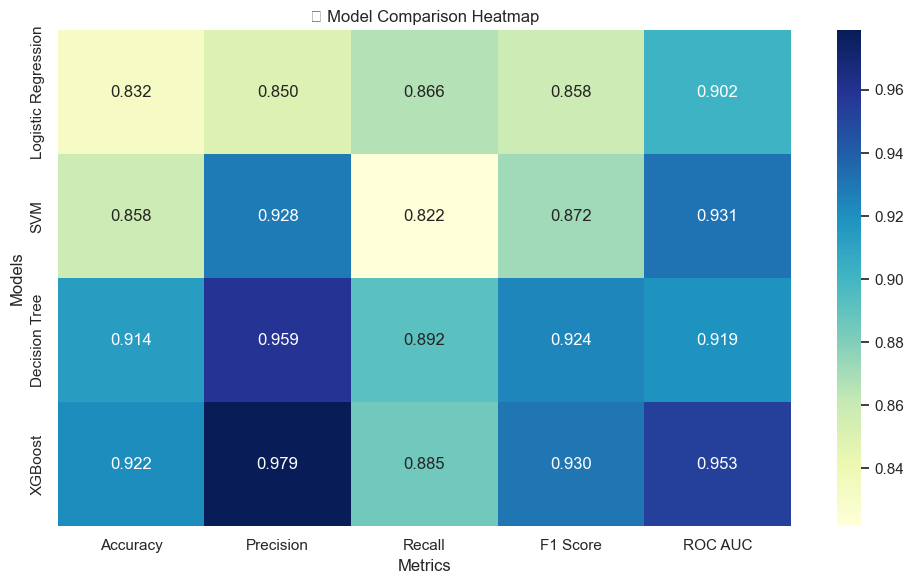

In [47]:
# Create DataFrame
results_df = pd.DataFrame(results).T  # Transpose to have models as rows

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("🔍 Model Comparison Heatmap")
plt.ylabel("Models")
plt.xlabel("Metrics")
plt.tight_layout()
plt.show()

# Hyperparametre tuning of XGBoost

In [48]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 2.0),
    }
    
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    # 5-fold CV for more stable objective
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

In [49]:
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.HyperbandPruner()

study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=50, timeout=600)  # adjust trials/time

print("🔧 Best params:", study.best_params)
print("🏆 Best ROC AUC (train):", study.best_value)

[I 2025-07-12 19:04:26,990] A new study created in memory with name: no-name-73cb8bcf-9944-43aa-8b4c-762a7d18220e
[I 2025-07-12 19:04:32,282] Trial 0 finished with value: 0.9802795529304337 and parameters: {'n_estimators': 196, 'max_depth': 9, 'learning_rate': 0.0011210466230851528, 'subsample': 0.7623945777623712, 'colsample_bytree': 0.8853852207365762, 'gamma': 0.6645287993121138, 'reg_lambda': 0.6075017844705637, 'reg_alpha': 0.0041556287341826155, 'scale_pos_weight': 1.0910763443042057}. Best is trial 0 with value: 0.9802795529304337.
[I 2025-07-12 19:04:36,101] Trial 1 finished with value: 0.9786872947944932 and parameters: {'n_estimators': 155, 'max_depth': 7, 'learning_rate': 0.07244573644575651, 'subsample': 0.8758633602746388, 'colsample_bytree': 0.9378822015948943, 'gamma': 0.45242591202638915, 'reg_lambda': 1.5595037322158214, 'reg_alpha': 5.30810249986633, 'scale_pos_weight': 1.1024977163032972}. Best is trial 0 with value: 0.9802795529304337.
[I 2025-07-12 19:04:40,952] Tr

🔧 Best params: {'n_estimators': 247, 'max_depth': 9, 'learning_rate': 0.031190613591202527, 'subsample': 0.7823502190660886, 'colsample_bytree': 0.9571812576785004, 'gamma': 0.44620587084254765, 'reg_lambda': 0.02813163555923087, 'reg_alpha': 0.27831679241265916, 'scale_pos_weight': 1.7999246243856462}
🏆 Best ROC AUC (train): 0.992181329293048


# Evaluate tuned model on Test set

In [50]:
best_model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_proba)

{'Accuracy': 0.914179104477612,
 'Precision': 0.9652777777777778,
 'Recall': 0.8853503184713376,
 'F1 Score': 0.9235880398671097,
 'ROC AUC': np.float64(0.9649394617547483)}

# Feature Importance

<Figure size 800x600 with 0 Axes>

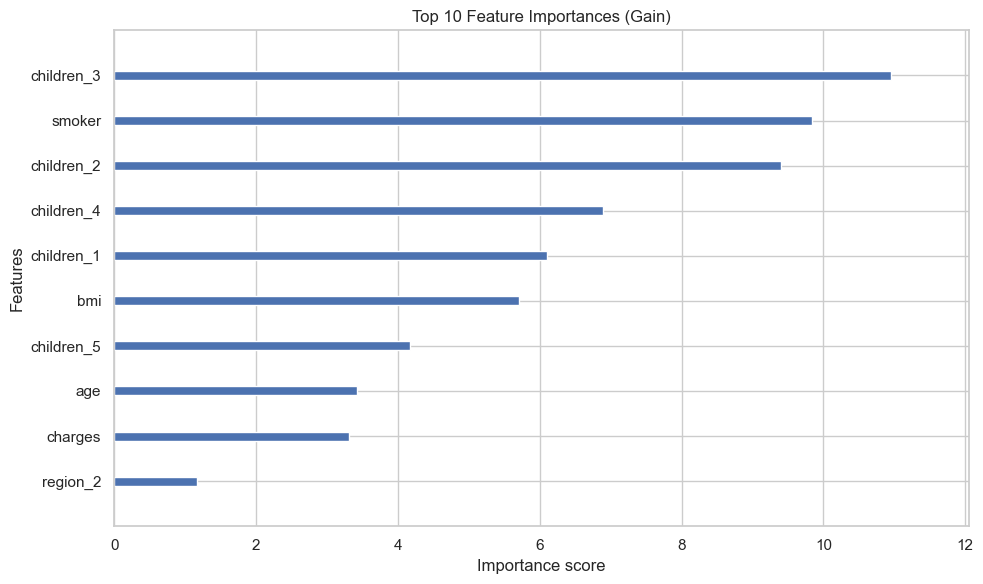

In [51]:
from xgboost import plot_importance

# Plot top features by Gain
plt.figure(figsize=(8, 6))
plot_importance(best_model, importance_type='gain', max_num_features=10,
                title='Top 10 Feature Importances (Gain)', show_values=False)
plt.tight_layout()
plt.show()


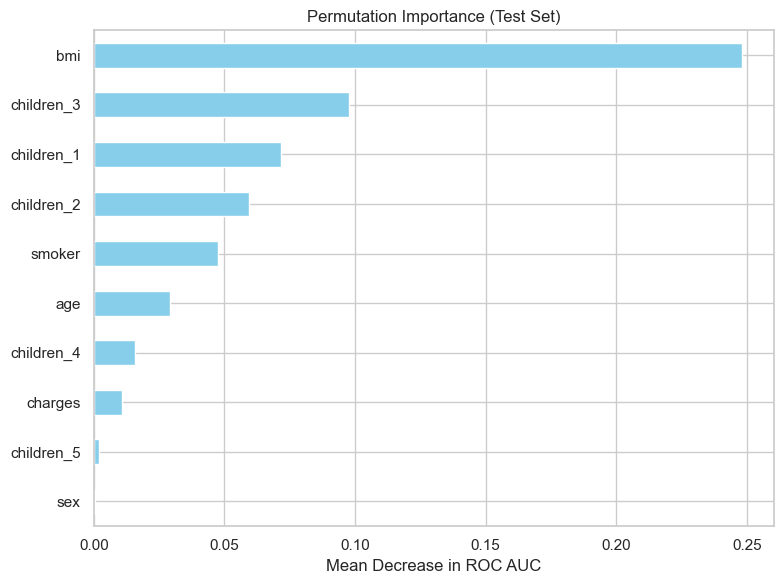

In [52]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(best_model, X_test, y_test, scoring='roc_auc', n_repeats=5, random_state=42)
perm_df = pd.Series(perm_imp.importances_mean, index=X_test.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
perm_df.tail(10).plot(kind='barh', color='skyblue')
plt.title("Permutation Importance (Test Set)")
plt.xlabel("Mean Decrease in ROC AUC")
plt.tight_layout()
plt.show()


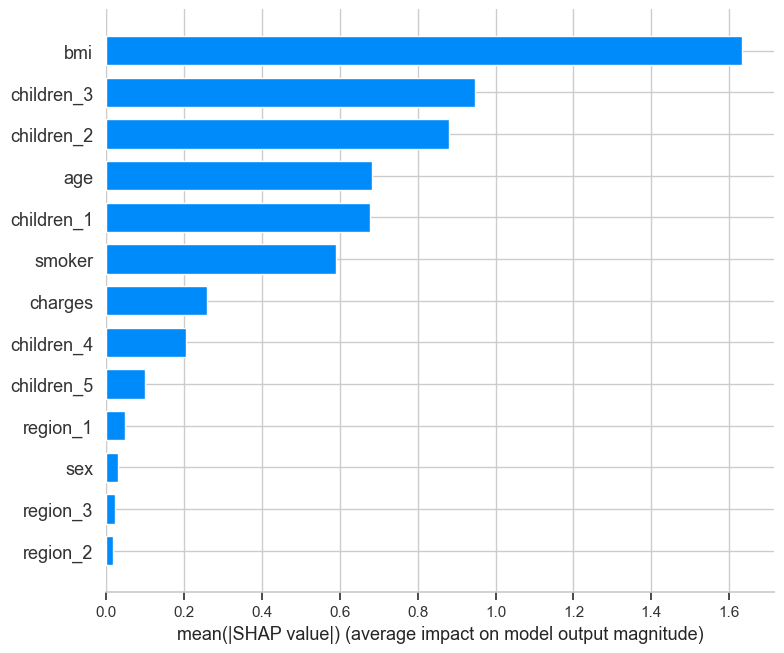

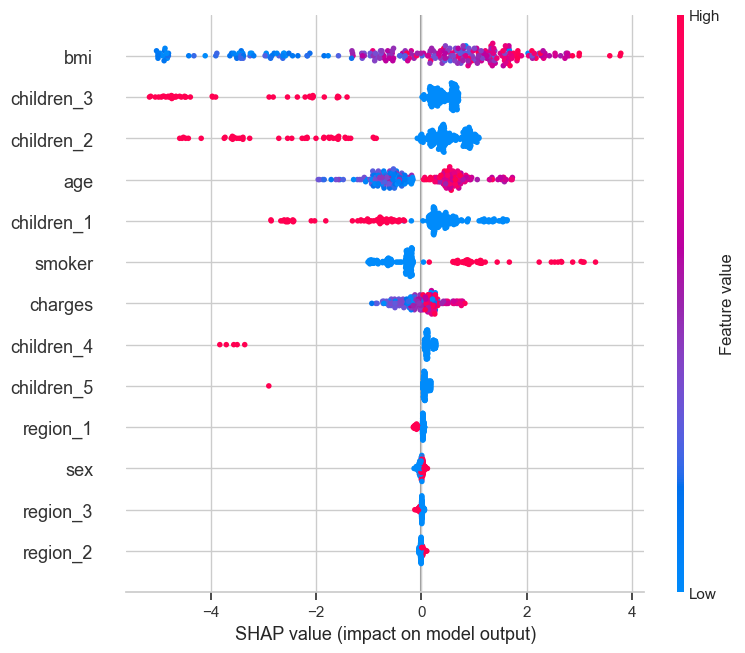

In [53]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary bar plot (global importance)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary plot (impact by value per feature)
shap.summary_plot(shap_values, X_test)


# Save the model

In [54]:
import pickle

# Save the trained model
with open("xgb_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Also save preprocessing objects if you have them (e.g., scaler, encoder)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

# Sample inputs

In [ ]:
import csv

# Sample data: list of dictionaries (one per row)
rows = [
    {"age": 28, "bmi": 22.5, "charges": 3200.00, "sex": "female", "smoker": "no", "region": "northeast", "children": 0},
    {"age": 45, "bmi": 27.8, "charges": 12000.50, "sex": "male",   "smoker": "yes", "region": "southwest", "children": 2},
    {"age": 32, "bmi": 31.2, "charges": 8000.00, "sex": "male",   "smoker": "no", "region": "southeast", "children": 1},
    {"age": 58, "bmi": 29.5, "charges": 20000.00,"sex": "female", "smoker": "yes","region": "northwest", "children": 3},
    {"age": 41, "bmi": 24.0, "charges": 6000.00, "sex": "male",   "smoker": "no", "region": "northeast", "children": 2},
    {"age": 50, "bmi": 33.7, "charges": 15000.00,"sex": "female", "smoker": "yes","region": "southwest", "children": 4},
]

# CSV filename
output_file = "sample_input.csv"

# Get the column headers from keys of the first dict
fieldnames = rows[0].keys()

# Write to CSV
with open(output_file, mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

print(f"✅ Sample CSV file '{output_file}' created with {len(rows)} rows.")
